In [409]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split
from catboost import CatBoost
from catboost.utils import eval_metric

In [410]:
paths = ['111.csv', '121.csv', '102.csv', '103.csv', '112.csv']

In [411]:
leap = 8
border_x = 12
window_size = 300
border_y = 0.08

In [412]:
def create_dataset(signal, peaks, window_size, leap, border_x, border_y):
    dataset = []
    for i in range(0, len(signal)-window_size, leap):
        piece = signal[i:i+window_size] / np.max(np.abs(signal[i:i+window_size]))
        piece = piece - np.mean(piece)
        is_peak = 0
        middle = int((i + i + window_size) / 2)
        for peak in peaks[0]:
            if peak >= middle - border_x and peak < middle + border_x and \
            (signal[peak] - signal[middle]) / np.max(np.abs(signal[i:i+window_size])) < border_y:
                is_peak = 1
                break
        piece = np.append(piece, is_peak)
        dataset.append(piece)
    return dataset

In [413]:
def new_booster(signal, window_size, leap, border_x, border_y):
    
    peaks = find_peaks(signal, distance=window_size)
    
    dataset = create_dataset(signal, peaks, window_size, leap, border_x, border_y)
    
    df = pd.DataFrame(dataset)
    df[window_size].sum()
    
    X_train, X_test, Y_train, Y_test = train_test_split(df.iloc[: , :window_size], df[window_size], test_size = 0.15)

    booster = CatBoost(params={'iterations':100, 'loss_function':'Logloss'})
    booster.fit(X_train, Y_train, eval_set=(X_test, Y_test))
    booster.set_feature_names([str(i) for i in range(window_size)])

    test_preds = booster.predict(X_test, prediction_type="Class")
    train_preds = booster.predict(X_train, prediction_type="Class")
    
    print("\nTest  Accuracy : %f"%eval_metric(Y_test.values, test_preds, "Accuracy")[0])
    print("Train Accuracy : %f"%eval_metric(Y_train.values, train_preds, "Accuracy")[0])
    print(len(Y_test.values))
    
    test = X_test
    
    return booster
    

In [414]:
all_signal = []
for path in paths:
    data = pd.read_csv(path)
    signal = data[data.columns[1]]
    signal = signal[0:20000]
    all_signal.extend(signal)
print(len(all_signal))
all_signal = np.array(all_signal)
print(all_signal.shape)
    

100000
(100000,)


In [415]:
booster = new_booster(all_signal, window_size, leap, border_x, border_y)

Learning rate set to 0.154557
0:	learn: 0.3693400	test: 0.3714170	best: 0.3714170 (0)	total: 41.1ms	remaining: 4.07s
1:	learn: 0.2072137	test: 0.2108196	best: 0.2108196 (1)	total: 81.1ms	remaining: 3.97s
2:	learn: 0.1240105	test: 0.1293136	best: 0.1293136 (2)	total: 121ms	remaining: 3.9s
3:	learn: 0.0852023	test: 0.0919021	best: 0.0919021 (3)	total: 162ms	remaining: 3.89s
4:	learn: 0.0658773	test: 0.0734039	best: 0.0734039 (4)	total: 202ms	remaining: 3.83s
5:	learn: 0.0537020	test: 0.0618042	best: 0.0618042 (5)	total: 249ms	remaining: 3.9s
6:	learn: 0.0469089	test: 0.0559278	best: 0.0559278 (6)	total: 289ms	remaining: 3.84s
7:	learn: 0.0406884	test: 0.0507298	best: 0.0507298 (7)	total: 330ms	remaining: 3.79s
8:	learn: 0.0363864	test: 0.0468040	best: 0.0468040 (8)	total: 370ms	remaining: 3.74s
9:	learn: 0.0340007	test: 0.0463358	best: 0.0463358 (9)	total: 410ms	remaining: 3.69s
10:	learn: 0.0323680	test: 0.0456268	best: 0.0456268 (10)	total: 457ms	remaining: 3.7s
11:	learn: 0.0302784	te

95:	learn: 0.0088664	test: 0.0437936	best: 0.0425318 (74)	total: 4.08s	remaining: 170ms
96:	learn: 0.0087729	test: 0.0437516	best: 0.0425318 (74)	total: 4.13s	remaining: 128ms
97:	learn: 0.0086742	test: 0.0437733	best: 0.0425318 (74)	total: 4.19s	remaining: 85.6ms
98:	learn: 0.0085573	test: 0.0441052	best: 0.0425318 (74)	total: 4.25s	remaining: 42.9ms
99:	learn: 0.0084496	test: 0.0443956	best: 0.0425318 (74)	total: 4.3s	remaining: 0us

bestTest = 0.04253179541
bestIteration = 74

Shrink model to first 75 iterations.

Test  Accuracy : 0.987166
Train Accuracy : 0.997262
1870


650000


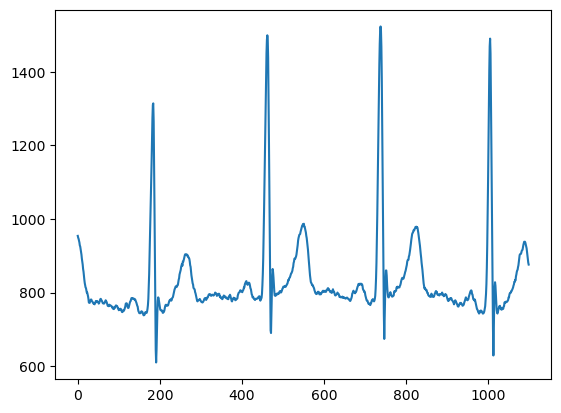

In [416]:
data_check = pd.read_csv('116.csv')
signal_check = data_check[data_check.columns[1]].values
print(len(signal_check))
signal_check = signal_check[0:50000]
plt.plot(signal_check[100:1200])

In [417]:
dataset_check = []
middles_check = []
for i in range(0, len(signal_check)-window_size, leap):
    piece = signal_check[i:i+window_size] / np.max(np.abs(signal_check[i:i+window_size]))
    piece = piece - np.mean(piece)
    middle = (i + i + window_size) / 2
    middles_check.append(middle)
    dataset_check.append(piece)


In [418]:
df_check = pd.DataFrame(dataset_check)

test_preds = booster.predict(df_check, prediction_type="Class")

In [419]:
test_preds.sum()

245.0

(0.0, 2000.0)

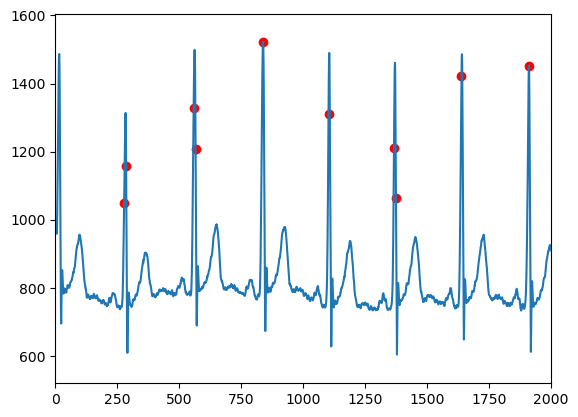

In [420]:
peaks = np.where(test_preds>0)[0]
middles_check = np.asarray(middles_check)
plt.plot(signal_check)
plt.scatter(middles[peaks], signal_check[np.array(middles[peaks], dtype = int)], color='red')
plt.xlim([0,2000])

В общем и целом, алгоритм рабоатет нормально, надо внимательно смотреть на датасет, так как как будто бы в первых колонках могут встречаться не только сигналы ЭКГ. Алгоритм показывает точность 99% на train выборке и 98% на test выборке. Для достижения таких результатов потребовалось подать 5 файлов.